In [15]:
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.utils import resample
from sklearn.metrics import pairwise
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods

In [16]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [17]:
n_features = 100
X, y = make_classification(n_clusters_per_class = 6, n_samples = 4000, n_features = n_features, n_informative = 20, random_state=8, flip_y= 0.01)
X_train, X_test = np.split(X, [200])
y_train, y_test = np.split(y, [200])
data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Lineal vs. Non-Lineal

In [18]:
@time_func
def RANDOM_SELECTION(CVal = 0.1, kernel='liblinear'):
    data.kernel = kernel
    with Pool(6) as pool:
        scores = pool.map(data.randomSelection, [CVal]*10)
    
    #scores = list(map(data.randomSelection, [0.1]))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores)

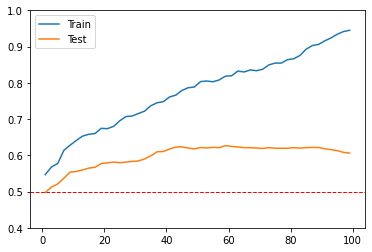

AT None WITH 0 ITERATIONS IN -1 SECONDS : -1
__main__.RANDOM_SELECTION - 00:00:02.370273800


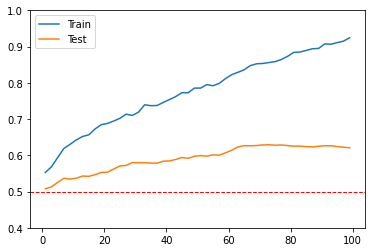

AT None WITH 0 ITERATIONS IN -1 SECONDS : -1
__main__.RANDOM_SELECTION - 00:00:04.079253800


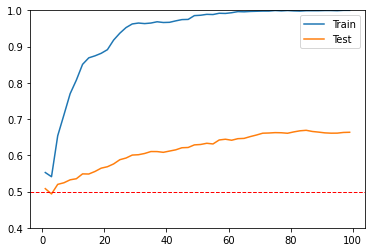

AT None WITH 0 ITERATIONS IN -1 SECONDS : -1
__main__.RANDOM_SELECTION - 00:00:06.089555300


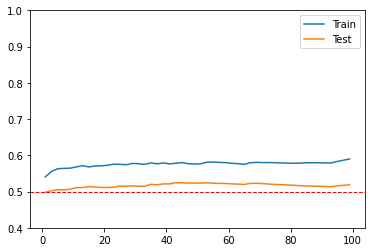

AT None WITH 0 ITERATIONS IN -1 SECONDS : -1
__main__.RANDOM_SELECTION - 00:00:04.583164900


In [19]:
RANDOM_SELECTION()
RANDOM_SELECTION(kernel='linear')

data.kernel_matrix = 'poly'
RANDOM_SELECTION(kernel='precomputed')

data.kernel_matrix = None
RANDOM_SELECTION(kernel='poly')

# SVM

In [20]:
@time_func
def SVM_RFE_W_STEP(step, kernel = 'linear', w1 = [0.8, 0.2]):
    data.kernel = 'precomputed'
    data.kernel_matrix = kernel
    data.C = 0.1
    kf = KFold(n_splits=10, shuffle=True)

    index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_kernel, index)

    #scores = list(map(data.svm_rfe_kernel, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    

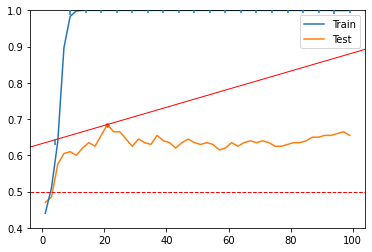

AT (21, 0.6849999999999999, 0.29400000000000004) WITH 20 ITERATIONS IN 2.339938735961914 SECONDS : 0.05506892646548295
__main__.SVM_RFE_W_STEP - 00:00:07.019281800


In [21]:
SVM_RFE_W_STEP(5, 'poly')

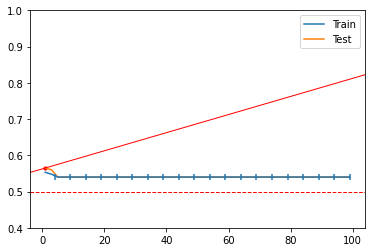

AT (1, 0.565, 0.3500000000000001) WITH 20 ITERATIONS IN 1.8486358165740966 SECONDS : 0.06099390571947879
__main__.SVM_RFE_W_STEP - 00:00:05.936959100


In [22]:
SVM_RFE_W_STEP(5, 'rbf')

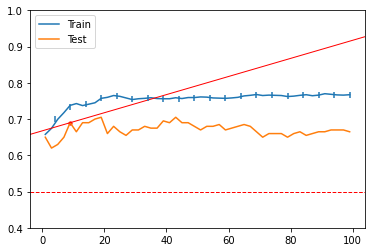

AT (9, 0.6900000000000001, 0.26599999999999996) WITH 20 ITERATIONS IN 1.3564547300338745 SECONDS : 0.07041208347853001
__main__.SVM_RFE_W_STEP - 00:00:04.854349300


In [23]:
SVM_RFE_W_STEP(5, 'linear')

In [24]:
def computeKernelMatrix(X, Y):
    return pairwise.polynomial_kernel(X, Y, degree=1)

def computeHessianMatrix(K, y):
    return np.multiply(np.multiply.outer(y, y), K)

In [25]:
X0 = data.X_train[:100]
y = data.y_train[:100]

features = np.array([2,3,5,7,9,10,11,12,15,16,18,19])
X = X0[:, features]

# Precompute Hessian Matrix
K = computeKernelMatrix(X, X)
H = computeHessianMatrix(K, y)

# Declare and train the SVM
estimator = SVC(C=0.1, max_iter=9000, kernel='precomputed')
estimator.fit(K, y)

a = np.ones(H.shape[0])
a[estimator.support_] = estimator.dual_coef_[0]

aHa = np.dot(np.dot(a, H), a) 
importances = np.zeros(X.shape[1])

In [26]:
X.shape

(100, 12)

In [27]:
flist = list(range(0, X.shape[1]))
for i in flist:
    X_i = X[:, np.delete(flist, i)]
    K_i = computeKernelMatrix(X_i, X_i)
    H_i = computeHessianMatrix(K_i, y)
    aH_ia = np.dot(np.dot(a, H_i), a) 
    importances[i] = (1/2) * (aHa - aH_ia)

In [28]:
importances

array([-2.57300754, -0.17946532, -2.46566481, -2.85665877, -2.81947664,
       -2.90038204, -2.50727285, -2.89188708, -2.78284456, -2.90053615,
       27.7584099 , -2.88121413])